In [1]:
from __future__ import division
import os
import numpy as np
import time
import matplotlib.pyplot as plt
import scipy as scp
import pylab as pyl

import warnings
warnings.filterwarnings('ignore')
np.random.seed(1234)

%matplotlib inline
%load_ext autoreload                                                                                                                                                                                                
%autoreload 

In [2]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
if not os.path.isdir('DampedNewtonPreconditioning_fordiffparam_images'):
    os.makedirs('DampedNewtonPreconditioning_fordiffparam_images')

In [4]:
"""To compute distance matrix"""
def distmat(x,y):
    return np.sum( x**2,0 )[:,None] + np.sum( y**2,0 )[None,:] - 2*x.transpose().dot(y)

"""To Normalise a vector"""
normalize = lambda a: a/np.sum( a )

"""To Compute P"""
def GetP(u,K,v):
    u = u.reshape(u.shape[0],)
    v = v.reshape(v.shape[0],)
    return u[:,None]*K*v[None,:]

def plotp(x, col,plt, scale=200, edgecolors="k"):
  return plt.scatter( x[0,:], x[1,:], s=scale, edgecolors=edgecolors,  c=col, cmap='plasma', linewidths=2 )

In [5]:
def generate_data(N):
    """
     N is a list of the size of the data on x and y
    """
    x = np.random.rand( 2,N[0] )-0.5
    theta = 2*np.pi*np.random.rand( 1,N[1] )
    r = 0.8+.2*np.random.rand( 1,N[1] )
    y = np.vstack( ( r*np.cos( theta ),r*np.sin( theta ) ) )
    return x,y


In [6]:
N = [ 500,600 ]
x,y = generate_data(N)

In [7]:
import computational_OT

## Damped Newton without Preconditioning

In [8]:
rho = 0.95
c = 0.05
DampedNewtonP = []
results_DampedNewton  = []
times_DampedNewton    = []
Hessians_DampedNewton = []

#epsilons=[0.05,0.08,0.1]
# epsilons=[0.1, 0.2, 0.3, 0.4, 0.5, 0.75, 1.0 ]
epsilons = [ 1.0, 0.75, 0.5, 0.4, 0.3, 0.1, 0.05,0.03 ]
#epsilons=[0.3]
for eps in epsilons:
    
    # Line Search
    print( "Damped Newton for epsilon="+str(eps)+":" )    
    #Cost matrix
    C = distmat(x,y)

    # a and b
    a = normalize( np.ones( N[0] ) )
    a = a.reshape( a.shape[0],-1 )
    b = normalize( np.ones( N[1] ) )
    b = b.reshape( b.shape[0],-1 )

    #Kernel
    K = np.exp(-C/eps)
    f,g = a,b

    print( "Doing for (",N[0],N[1],")." )
    print( " |- Iterating" )  
    start = time.time()
    Optimizer = computational_OT.DampedNewton( K,a,b,f,g,eps,rho,c )
    out = Optimizer._update( maxiter = 50 )
    results_DampedNewton.append( out )
    end = time.time()
    times_DampedNewton.append( end-start )
    print( " |- Computing P" )
    DampedNewtonP.append( GetP(np.exp(out['potential_f']/eps),K,np.exp(out['potential_g']/eps)) )
    print( " |- Recording (unstabilized) Hessian \n" )

    mat  = -eps*Optimizer.Hessian
    diag = 1/np.sqrt( np.vstack( (a,b) ) ).flatten()
    mat = diag[:,None]*mat*diag[None,:]
    Hessians_DampedNewton.append( mat )


Damped Newton for epsilon=1.0:
Doing for ( 500 600 ).
 |- Iterating
Terminating after iteration:  16
 |- Computing P
 |- Recording (unstabilized) Hessian 

Damped Newton for epsilon=0.75:
Doing for ( 500 600 ).
 |- Iterating
Terminating after iteration:  16
 |- Computing P
 |- Recording (unstabilized) Hessian 

Damped Newton for epsilon=0.5:
Doing for ( 500 600 ).
 |- Iterating
Terminating after iteration:  18
 |- Computing P
 |- Recording (unstabilized) Hessian 

Damped Newton for epsilon=0.4:
Doing for ( 500 600 ).
 |- Iterating
Terminating after iteration:  16
 |- Computing P
 |- Recording (unstabilized) Hessian 

Damped Newton for epsilon=0.3:
Doing for ( 500 600 ).
 |- Iterating
Terminating after iteration:  15
 |- Computing P
 |- Recording (unstabilized) Hessian 

Damped Newton for epsilon=0.1:
Doing for ( 500 600 ).
 |- Iterating
Terminating after iteration:  15
 |- Computing P
 |- Recording (unstabilized) Hessian 

Damped Newton for epsilon=0.05:
Doing for ( 500 600 ).
 |- Iter

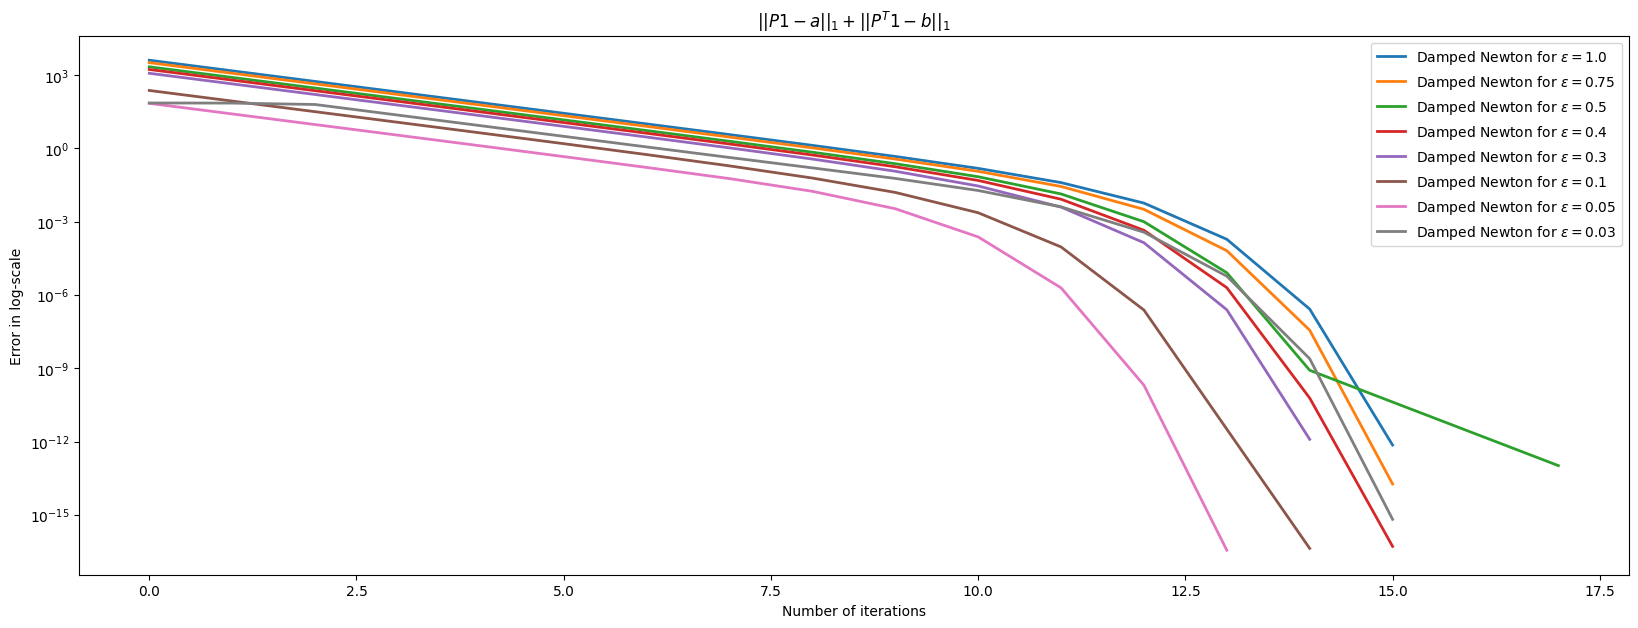


 Error plots can increase! The error is not the objective function!


In [9]:
plt.figure( figsize = (20,7) )
plt.title( "$$" )
plt.title( "$||P1 -a||_1+||P^T 1 -b||_1$" )

for i in range(len(results_DampedNewton)):
  error = np.asarray( results_DampedNewton[i]['error_a'] )+np.asarray( results_DampedNewton[i]['error_b'] )
  plt.plot( error,label='Damped Newton for $\epsilon=$'+ str(epsilons[i]), linewidth = 2 )

plt.xlabel( "Number of iterations" )
plt.ylabel( "Error in log-scale" )
plt.legend()
plt.yscale( 'log' )
plt.savefig( "DampedNewtonPreconditioning_Benchmark_images/ErrorDampedNewton.png" )
plt.show()

print( "\n Error plots can increase! The error is not the objective function!" )

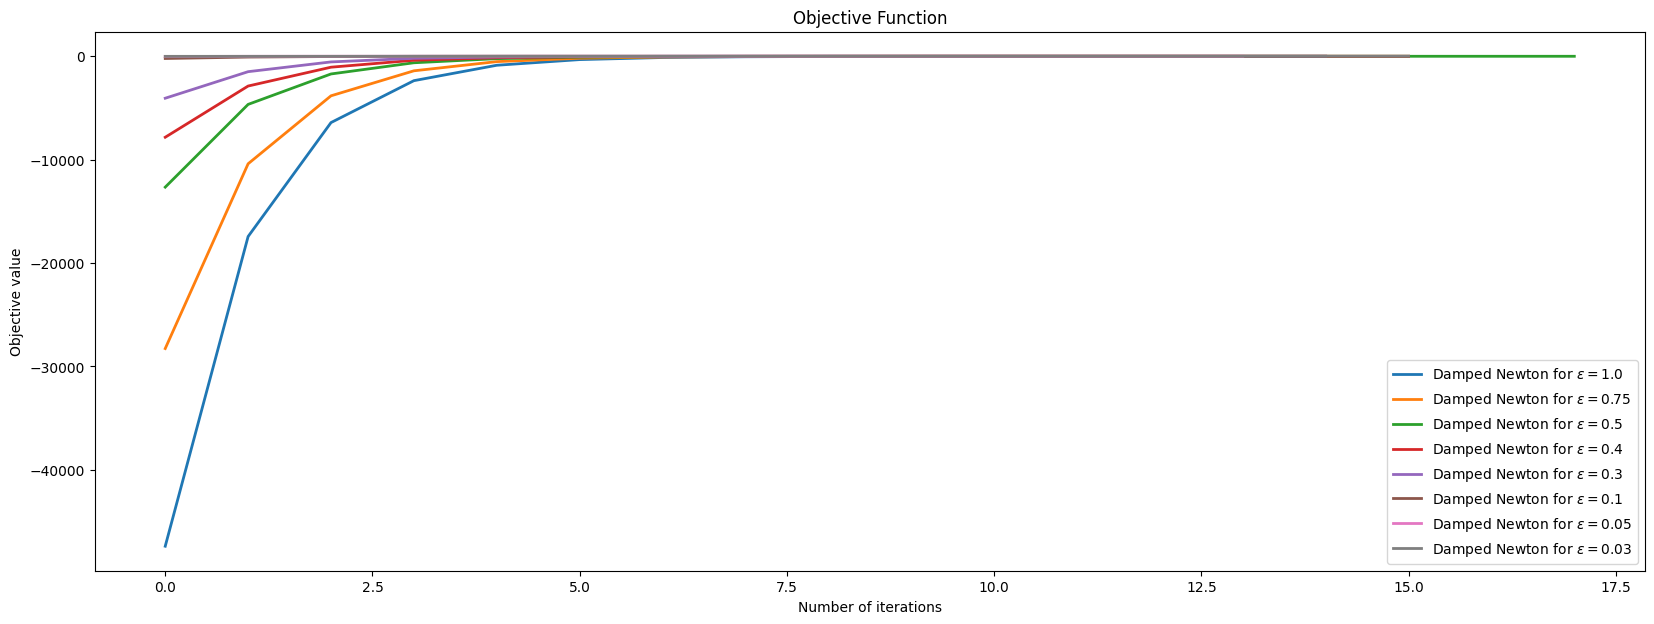

In [10]:
plt.figure( figsize = (20,7) )
plt.title( "$$" )

plt.title( "Objective Function" )
for i in range(len(results_DampedNewton)):
  plt.plot( np.asarray( results_DampedNewton[i]["objectives"] ),label='Damped Newton for $\epsilon=$'+ str(epsilons[i]), linewidth = 2 )

plt.xlabel( "Number of iterations" )
plt.ylabel( "Objective value" )
plt.legend()
plt.savefig("DampedNewtonPreconditioning_Benchmark_images/ObjectiveDampedNewton.png")
plt.show()


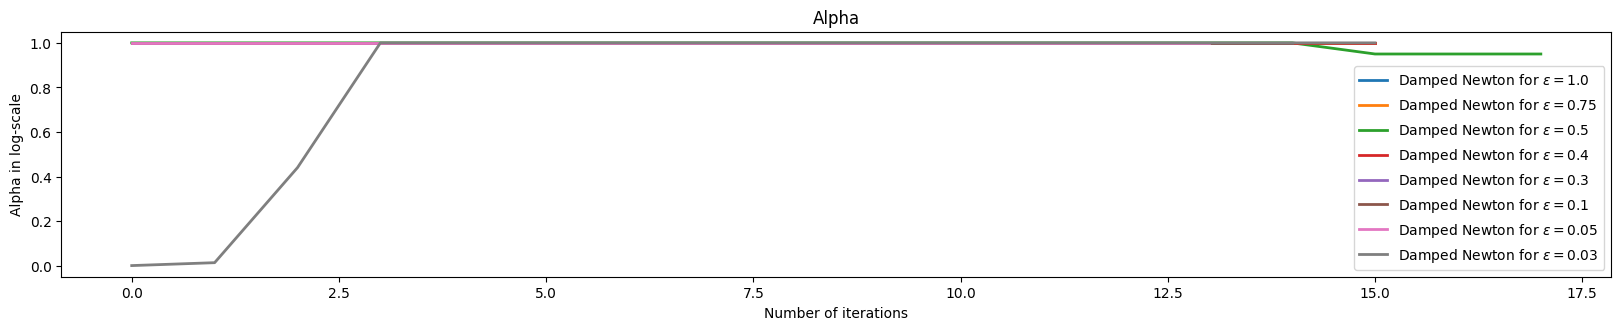

In [11]:
plt.figure( figsize = (20,7) )
plt.subplot(2,1,1),
plt.title( "Alpha" )

for i in range(len(results_DampedNewton)):
  plt.plot( np.asarray( results_DampedNewton[i]['linesearch_steps'] ),label='Damped Newton for $\epsilon=$'+ str(epsilons[i]), linewidth = 2 )

plt.xlabel( "Number of iterations" )
plt.ylabel( "Alpha in log-scale" )
plt.legend()
# plt.yscale( 'log')
plt.savefig("DampedNewtonPreconditioning_Benchmark_images/AlphaDampedNewton.png")
plt.show()

In [12]:
def spectral_decomposition(mat):
    eig, v = np.linalg.eigh( mat )
    sorting_indices = np.argsort(eig)
    eig = eig[sorting_indices]
    v   = v[:, sorting_indices]
    
    print( "List of smallest eigenvalues: ", eig[:10])
    print( "List of largest  eigenvalues: ", eig[-10:])

    return eig,v

In [13]:
eigs = []
eigvecs = []
for i in range( len(epsilons) ) :
    eps = epsilons[i]
    print( "Spectral statistics of Hessian for epsilon="+str(eps) )
    ev = spectral_decomposition( Hessians_DampedNewton[i] )
    eigs.append( ev[0] )
    eigvecs.append( ev[1] )
    print("")


Spectral statistics of Hessian for epsilon=1.0
List of smallest eigenvalues:  [2.94915517e-16 6.48491216e-01 6.64971373e-01 9.15828325e-01
 9.43787608e-01 9.89050294e-01 9.89609419e-01 9.90278853e-01
 9.98507480e-01 9.98619512e-01]
List of largest  eigenvalues:  [1.00138619 1.00149835 1.00972646 1.01039498 1.0109542  1.05621705
 1.08417596 1.33503346 1.35151358 2.00000537]

Spectral statistics of Hessian for epsilon=0.75
List of smallest eigenvalues:  [9.36756057e-17 5.58898894e-01 5.78150554e-01 8.64967502e-01
 9.07379136e-01 9.77247521e-01 9.78096780e-01 9.83717649e-01
 9.96606664e-01 9.96802247e-01]
List of largest  eigenvalues:  [1.00319848 1.00339391 1.01628313 1.02190378 1.02275302 1.09262145
 1.13503307 1.42185007 1.44110173 2.00000067]

Spectral statistics of Hessian for epsilon=0.5
List of smallest eigenvalues:  [5.89805983e-17 4.23862028e-01 4.45177314e-01 7.60246766e-01
 8.26259253e-01 9.41341914e-01 9.43222244e-01 9.68995164e-01
 9.87868093e-01 9.88516659e-01]
List of large

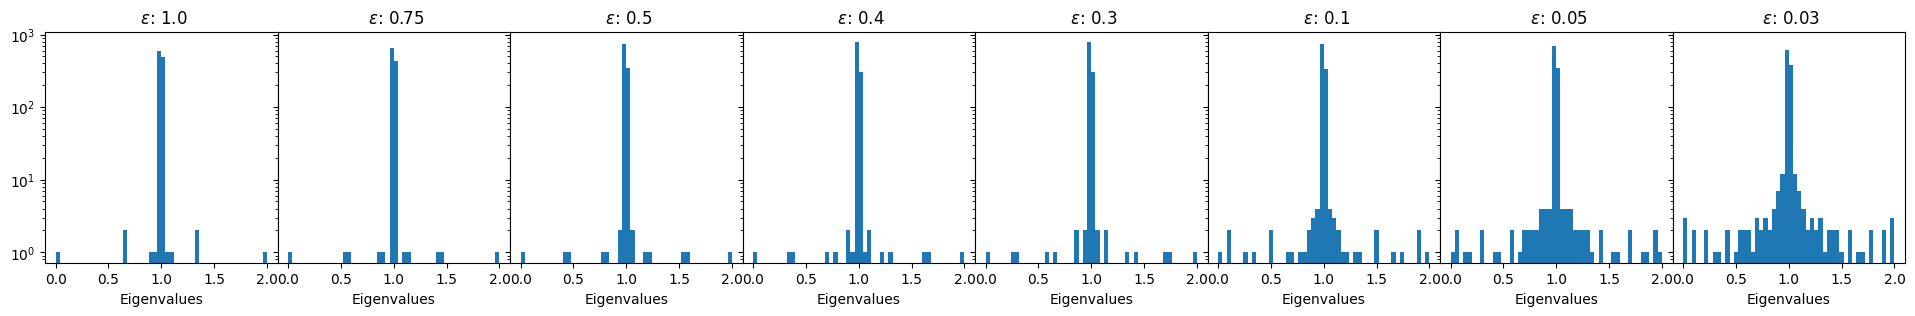

In [14]:
fig,ax = plt.subplots( figsize=(24,3),nrows=1, ncols=len(epsilons), sharey=True )
plt.title( "Histogram of eigenvalues." )
for i in range( len(epsilons) ):
    ax[i].hist( eigs[i], 50 )
    ax[i].set_title( " $\epsilon$: "+str(epsilons[i]) )
    ax[i].set_xlabel( "Eigenvalues" )
    ax[i].set_yscale( "log" )
plt.subplots_adjust( wspace=0,hspace=0 )
plt.savefig("DampedNewtonPreconditioning_Benchmark_images/eigenhistunstabilized.png")
plt.show()

In [15]:
def build_preconditioners( num_eigs,modified_Hessian, ansatz=True ):
    # Diagonalize
    eigenvalues, eigenvectors = np.linalg.eigh( modified_Hessian )
    sorting_indices = np.argsort( eigenvalues )
    eigenvalues  = eigenvalues[sorting_indices]
    eigenvectors = eigenvectors[:, sorting_indices]
    # Form null vector
    if not ansatz:
        null_vector = eigenvectors[:, 0]
    else:
        null_vector = np.hstack( (np.ones(N[0]), -np.ones(N[1])) )
        norm = np.sqrt( N[0] + N[1] )
        null_vector = null_vector/norm
    # Form other vectors (only 13)
    n,m = eigenvectors.shape
    indices = []
    for i in range(num_eigs//2):
        indices.append(m-i-1)
        indices.append(i+1)

    if num_eigs%2!=0:
        indices.append(m-1-(num_eigs//2))
    precond_vectors = eigenvectors[:, indices ]
    precond_vectors = []
    for index in indices:
        precond_vectors.append( eigenvectors[:,index] )
    #
    return null_vector, precond_vectors

In [16]:
num_eigs = 10
null_vector, precond_vectors = build_preconditioners( num_eigs, Hessians_DampedNewton[-1], ansatz = False )

In [23]:
rho = 0.95
c = 0.05
reset_starting_point = True
final_modified_Hessians = []
DampedNewtonP = []
results_DampedNewton  = []
times_DampedNewton    = []

#epsilons = [ 0.05,0.08,0.1 ]
# precond_epsilons = [ 0.2, 0.3, 0.4, 0.5, 0.75, 1.0 ]
# precond_epsilons = [  0.001 ]
# precond_epsilons = [ 0.001 ]
precond_epsilons = [  0.03, 0.02, 0.009, 0.005, 0.001 ]
precond_epsilons = [ 0.02 ]
f, g = None, None
for eps in precond_epsilons:
    # Line Search
    print( "Damped Newton for epsilon="+str(eps)+":" )    
    # Cost matrix
    C = distmat(x,y)

    # a and b
    a = normalize( np.ones(N[0]) )
    a = a.reshape( a.shape[0],-1 )
    b = normalize( np.ones(N[1]) )
    b = b.reshape( b.shape[0],-1 )

    #Kernel
    K = np.exp(-C/eps)

    if (f is None) or (g is None): 
        f,g = a,b

    print( "Doing for (",N[0],N[1],")." )
    print( " |- Iterating" )  
    start = time.time()
    Optimizer = computational_OT.DampedNewton_With_Preconditioner( K,a,b,f,g,eps,rho,c,null_vector,precond_vectors[:] )
    out = Optimizer._update( maxiter=50, iterative_inversion=30, version=None,debug=False, optType='cg' )
    results_DampedNewton.append( out )
    end = time.time()
    
    times_DampedNewton.append(end-start)
    print( " |- Computing P" )

    if not reset_starting_point:
        f = Optimizer.x[:a.shape[0]]
        g = Optimizer.x[a.shape[0]:]
        # f = f.reshape( f.shape[0], -1)
        # g = g.reshape( g.shape[0], -1)
    
    

    
    DampedNewtonP.append( GetP(np.exp(out['potential_f']/eps),K,np.exp(out['potential_g']/eps)) )
    final_modified_Hessians.append( Optimizer.modified_Hessian )


Damped Newton for epsilon=0.02:
Doing for ( 500 600 ).
 |- Iterating
values max:  0.3571888358632216  values min:  -0.17157109293210604
z max:  0.020307293980743144  z min:  -0.021548649820087657
gradient  norm:  2493.421996719573
gradient.T Hessian gradient:  [[6218318.69314026]]
inverse norm 5461.5992873582345
norm epsilon*inverse 109.23198574716467
max of p_k x  33.35379908883651
 diag norm:  1248102.8921862806
ApplyP without diag multiplication p_k-norm:  117.95475670308599
diag[:,None]*x p_k-norm:  32645948.020179253
Transform p_k norm:  32645948.020179253
Transform p_k norm:  32644077.650134336
Terminating after iteration:  1
 |- Computing P


In [18]:
plt.figure( figsize = (20,7) )
plt.plot( x,label='Damped Newton for $\epsilon=$'+ str(precond_epsilons[i]), linewidth = 2 )
plt.xlabel( "Number of iterations" )
plt.ylabel( "Error in log-scale" )
plt.legend()
plt.yscale( 'log' )
plt.show()


IndexError: list index out of range

<Figure size 2000x700 with 0 Axes>

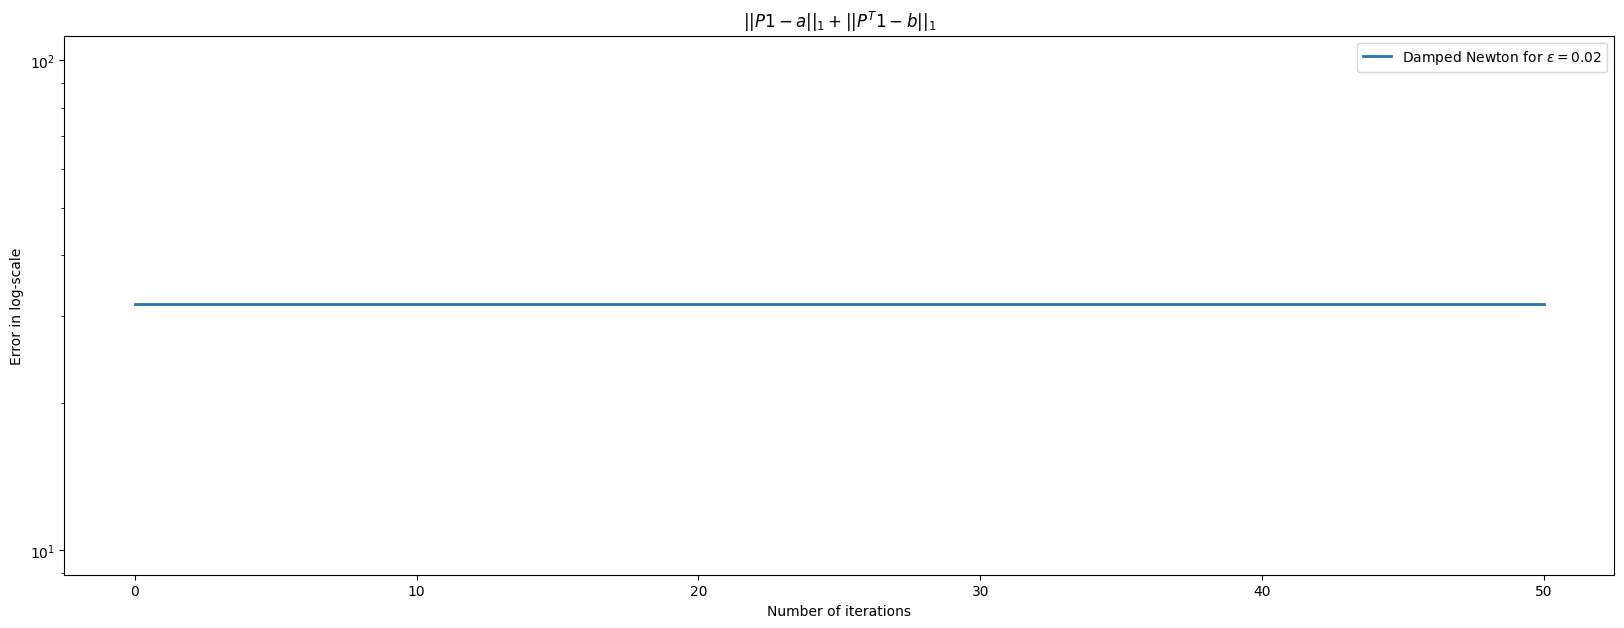


 Error plots can increase! The error is not the objective function!


In [ ]:
plt.figure( figsize = (20,7) )
plt.title( "$$" )
plt.title( "$||P1 -a||_1+||P^T 1 -b||_1$" )

for i in range( len(results_DampedNewton) ):
  error = np.asarray( results_DampedNewton[i]['error_a'] ) + np.asarray( results_DampedNewton[i]['error_b'] )
  plt.plot( error,label='Damped Newton for $\epsilon=$'+ str(precond_epsilons[i]), linewidth = 2 )

plt.xlabel( "Number of iterations" )
plt.ylabel( "Error in log-scale" )
plt.legend()
plt.yscale( 'log' )
plt.savefig( "DampedNewtonPreconditioning_Benchmark_images/ErrorDampedNewton_final_cgIt30_5eig.png" )
plt.show()
print( "\n Error plots can increase! The error is not the objective function!" )

ValueError: x and y can be no greater than 2D, but have shapes (1,) and (1, 4, 1100, 1)

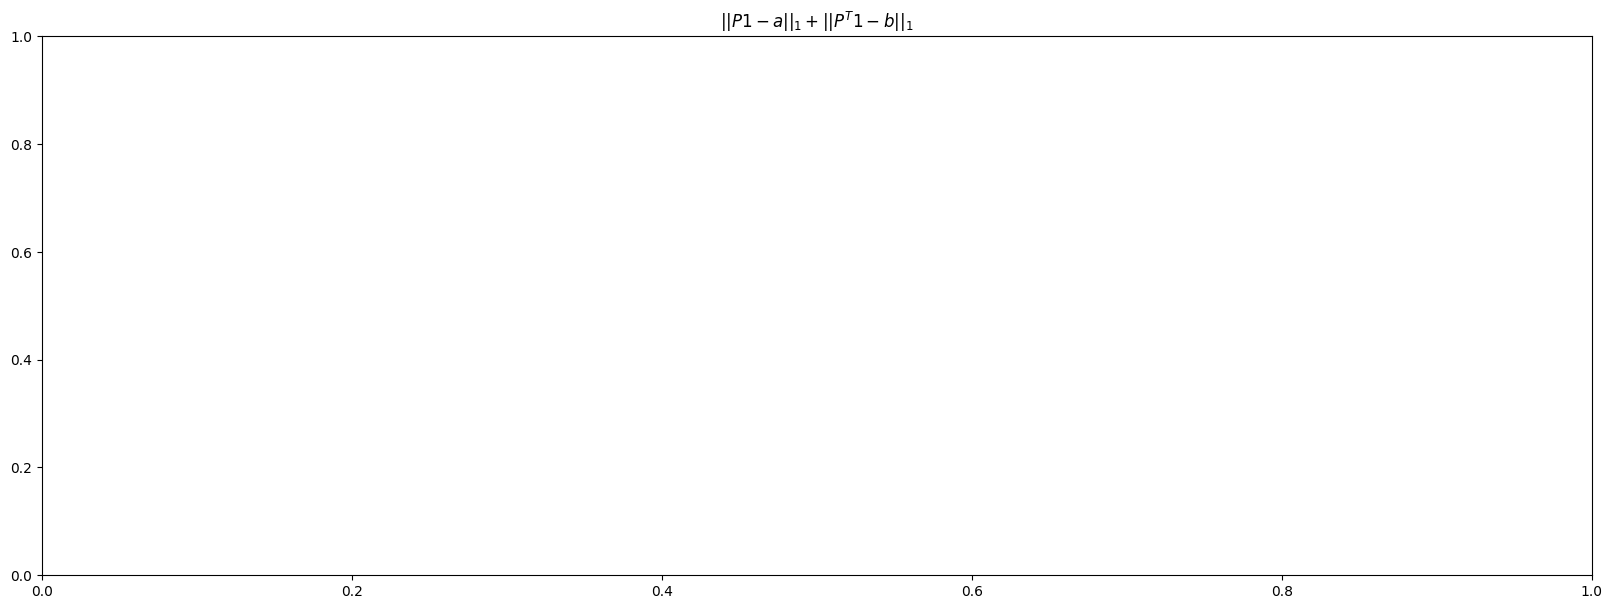

In [ ]:
plt.figure( figsize = (20,7) )
plt.title( "$$" )
plt.title( "$||P1 -a||_1+||P^T 1 -b||_1$" )

for i in range( len(results_DampedNewton) ):
  error = np.asarray( results_DampedNewton[i]['out'] ) 
  plt.plot( error,label='Damped Newton for $\epsilon=$'+ str(precond_epsilons[i]), linewidth = 2 )

plt.xlabel( "Number of iterations" )
plt.ylabel( "Error in log-scale" )
plt.legend()
plt.yscale( 'log' )
plt.show()
print( "\n Error plots can increase! The error is not the objective function!" )